# Complicated VO

In [11]:
import numpy as np
import math

In [12]:
ROBOT_RADIUS = 0.3
OBS_RADIUS = 0.2
obs_position = np.array([4.5, 5.0])
x = np.array([3.0, 4.0, math.pi / 8.0, 0, 0.0])
u = np.array([0.3, 1.9])
dt = 0.2

In [13]:
def compute_velocity_obstacle(robot_pos, robot_vel, robot_radius, obs_pos, obs_radius, max_speed):
    """Compute velocity obstacle for circular robot and obstacle in a 2D space."""
    
    # Compute relative position and velocity of obstacle
    rel_pos = obs_pos - robot_pos
    rel_vel = np.array([0.0, 0.0]) - robot_vel
    
    # Compute discriminant for quadratic equation
    a = np.dot(rel_vel, rel_vel) - max_speed**2
    b = 2 * np.dot(rel_vel, rel_pos)
    c = np.dot(rel_pos, rel_pos) - (robot_radius + obs_radius)**2
    discriminant = b**2 - 4*a*c
    
    # Check if there is a valid solution for time-to-collision
    if discriminant < 0:
        # No intersection point, full velocity space is valid
        vo_left = -max_speed
        vo_right = max_speed
    else:
        # Compute time-to-collision for both intersection points
        ttc1 = (-b - np.sqrt(discriminant)) / (2*a)
        ttc2 = (-b + np.sqrt(discriminant)) / (2*a)
        
        # Compute intersection points
        ip1 = robot_pos + (robot_vel * ttc1)
        ip2 = robot_pos + (robot_vel * ttc2)
        
        # Compute unit tangent vector from robot to obstacle
        tan_vec = rel_pos / np.linalg.norm(rel_pos)
        norm_vec = np.array([-tan_vec[1], tan_vec[0]])
        
        # Compute velocity space for each intersection point
        vo_left_1 = np.dot(-robot_vel + max_speed * tan_vec, norm_vec)
        vo_right_1 = np.dot(-robot_vel + max_speed * tan_vec, -norm_vec)
        vo_left_2 = np.dot(-robot_vel + max_speed * tan_vec, norm_vec)
        vo_right_2 = np.dot(-robot_vel + max_speed * tan_vec, -norm_vec)
        
        # Take the union of the velocity spaces
        vo_left = max(vo_left_1, vo_left_2, -max_speed)
        vo_right = min(vo_right_1, vo_right_2, max_speed)
        
    return vo_left, vo_right


# Simple Velocity Obstacle

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
from dataclasses import dataclass
@dataclass
class Config:
    """
    simulation parameter class
    """
    # robot parameter
    # Max U[0]
    max_speed = 0.3  # [m/s]
    # Min U[0]
    min_speed = -0.1  # [m/s]
    # Max and Min U[1]
    # max_yaw_rate = 40.0 * math.pi / 180.0  # [rad/s]
    max_yaw_rate = 1.9  # [rad/s]

    # The action can be the relative change in speed -0.2 to 0.2
    # max_accel = 0.2  # [m/ss]
    # max_delta_yaw_rate = 40.0 * math.pi / 180.0  # [rad/ss]

    # yaw_rate_resolution = 0.1 * math.pi / 180.0  # [rad/s]
    dt = 0.2  # [s] Time tick for motion prediction
    robot_radius = 0.3  # [m] for collision check

    bottom_limit = -0.5
    upper_limit = 11.5

    right_limit = 11.5
    left_limit = -0.5
    obs_size = 0.2

    num_discrete_actions = 5

    # obstacles [x(m) y(m), ....]
    ob = np.array([
        [4.5, 5.0],
        [5.0, 4.5],
        [5.0, 5.0],
        [5.0, 5.5],
        [5.5, 5.0],
    ])


In [15]:
def plot_robot(x, y, yaw, config, ax):
    circle = plt.Circle((x, y), config.robot_radius, color="b")
    ax.add_artist(circle)
    out_x, out_y = (np.array([x, y]) +
                    np.array([np.cos(yaw), np.sin(yaw)]) * config.robot_radius)
    ax.plot([x, out_x], [y, out_y], "-k")


def plot_frame(i, goal, config, ax, x):
    ob = config.ob
    ax.clear()
    # ROBOT POSITION
    ax.plot(x[0], x[1], "xr")
    # GOAL POSITION
    ax.plot(goal[0], goal[1], "xb")
    # OBSTACLES
    ax.plot(ob[:, 0], ob[:, 1], "ok")
    # BOX AROUND ROBOT
    plot_robot(x[0], x[1], x[2], config, ax)

    ax.set_xlim([config.left_limit, config.right_limit])
    ax.set_ylim([config.bottom_limit, config.upper_limit])
    # ax.axis("equal")
    ax.grid(True)
    
def motion(x: np.ndarray, u: np.ndarray) -> np.ndarray:
    """
    Describes how the robot moves
    :param x: current robot state
    :param u: action performed by the robot
    :return: the new robot state
    """
    dt = 0.2
    new_x = np.array(x, copy=True)

    # angle
    new_x[2] += u[1] * dt
    # vel lineare
    new_x[3] = u[0]
    # vel angolare
    new_x[4] = u[1]
    # x
    new_x[0] += u[0] * math.cos(new_x[2]) * dt
    # y
    new_x[1] += u[0] * math.sin(new_x[2]) * dt

    return new_x

def velocity_obstacle_complete(x, obs, dt):
    left_cone = np.inf
    right_cone = -np.inf
    for ob in obs:
        dist_to_ob = math.hypot(ob[0] - x[0], ob[1] - x[1])
        beta = math.asin((ROBOT_RADIUS+OBS_RADIUS)/dist_to_ob)
        
        beta = math.atan2(math.sin(beta), math.cos(beta))

        theta = math.atan2(ob[1] - x[1], ob[0] - x[0])
        forbidden_angles = [theta-beta-x[2], theta+beta-x[2]]
        forbidden_ang_vel = [a/dt for a in forbidden_angles]
        left_cone = min(left_cone, forbidden_ang_vel[0])
        right_cone = max(right_cone, forbidden_ang_vel[1])
    return left_cone, right_cone

def velocity_obstacle_nearest(x, obs, dt):
    left_cone = np.inf
    right_cone = -np.inf
    distances = [math.hypot(ob[0] - x[0], ob[1] - x[1]) for ob in obs]
    dist_to_ob_idx = np.argmin(distances)
    dist_to_ob = distances[dist_to_ob_idx]
    ob = obs[dist_to_ob_idx]
    beta = math.asin((ROBOT_RADIUS+OBS_RADIUS)/dist_to_ob)

    beta = math.atan2(math.sin(beta), math.cos(beta))

    theta = math.atan2(ob[1] - x[1], ob[0] - x[0])
    forbidden_angles = [theta-beta-x[2], theta+beta-x[2]]
    forbidden_ang_vel = [a/dt for a in forbidden_angles]
    left_cone = min(left_cone, forbidden_ang_vel[0])
    right_cone = max(right_cone, forbidden_ang_vel[1])
    return left_cone, right_cone

In [43]:
import math

def velocity_obstacle(p1, v1, r1, p2, v2, r2):
    """
    Computes the velocity obstacle for two agents in a 2D space.
    
    Parameters:
    p1 (tuple): position of agent 1 (x, y)
    v1 (tuple): velocity of agent 1 (x, y)
    r1 (float): radius of agent 1
    p2 (tuple): position of agent 2 (x, y)
    v2 (tuple): velocity of agent 2 (x, y)
    r2 (float): radius of agent 2
    
    Returns:
    tuple: the two edges of the velocity obstacle (u1, u2)
    """
    
    # Compute relative velocity and position
    rel_v = (v2[0] - v1[0], v2[1] - v1[1])
    rel_p = (p2[0] - p1[0], p2[1] - p1[1])
    
    # Compute time to collision
    a = rel_v[0] ** 2 + rel_v[1] ** 2
    b = 2 * (rel_v[0] * rel_p[0] + rel_v[1] * rel_p[1])
    c = rel_p[0] ** 2 + rel_p[1] ** 2 - (r1 + r2) ** 2
    disc = b ** 2 - 4 * a * c
    
    if disc < 0:
        # No collision possible, return full velocity space
        return ((-math.inf, math.inf), (-math.inf, math.inf))
    else:
        t_coh = (-b - math.sqrt(disc)) / (2 * a)
        
        # Compute the edges of the velocity obstacle
        u_tan = (rel_v[1], -rel_v[0])
        u1 = (0, 0)
        u2 = (0, 0)
        
        if t_coh > 0:
            u1 = (rel_v[0] * t_coh + r1 * u_tan[0], rel_v[1] * t_coh + r1 * u_tan[1])
            u2 = (rel_v[0] * t_coh - r2 * u_tan[0], rel_v[1] * t_coh - r2 * u_tan[1])
        
        return (u1, u2)


In [41]:
ROBOT_RADIUS = 0.3
OBS_RADIUS = 0.2
ob = np.array([4.5, 5.0])
x = np.array([4.0, 4.0, math.pi / 8.0, 0, 0.0])
u = np.array([0.3, 1.9])
goal = np.array([10, 10])
dt = 0.2

[0.0, 0.0]


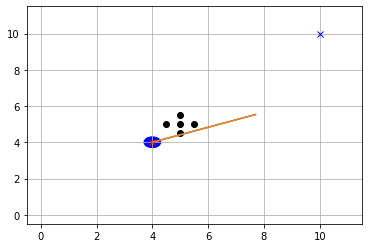

In [42]:
fig, axis = plt.subplots()
c = Config()
plot_frame(i=0, goal=goal, config=c, ax=axis, x=x)

forbidden_ang_vel = compute_VO_cone(robot_pos=x[:2], robot_radius=ROBOT_RADIUS, robot_ang_vel=math.pi/8.0, obstacle_pos=ob, obstacle_radius=OBS_RADIUS, obstacle_vel=0)
print(forbidden_ang_vel)

left_tangent = motion(x, [20, forbidden_ang_vel[0]])
right_tangent = motion(x, [20, forbidden_ang_vel[1]])

x_values = [x[0], left_tangent[0]]
y_values = [x[1], left_tangent[1]]
axis.plot(x_values, y_values)

x_values = [x[0], right_tangent[0]]
y_values = [x[1], right_tangent[1]]
axis.plot(x_values, y_values)
plt.show()
fig.savefig('VO.png', dpi=300)

In [20]:
a = [-0.42865689826985104, 2.381692116758285]

In [28]:
in_range = lambda x, rng: rng[0]<=x<=rng[1]

In [32]:
n = 2.3
in_range(n , a)

True

# Velocity Obstacle V2

In [104]:
def velocity_obstacle(p1, v1, r1, p2, v2, r2):
    """
    Computes the velocity obstacle for two agents in a 2D space.
    
    Parameters:
    p1 (tuple): position of agent 1 (x, y)
    v1 (tuple): velocity of agent 1 (x, y)
    r1 (float): radius of agent 1
    p2 (tuple): position of agent 2 (x, y)
    v2 (tuple): velocity of agent 2 (x, y)
    r2 (float): radius of agent 2
    
    Returns:
    tuple: the two edges of the velocity obstacle (u1, u2)
    """
    
    # Compute relative velocity and position
    rel_v = (v2[0] - v1[0], v2[1] - v1[1])
    rel_p = (p2[0] - p1[0], p2[1] - p1[1])
    
    # Compute time to collision
    a = rel_v[0] ** 2 + rel_v[1] ** 2
    b = 2 * (rel_v[0] * rel_p[0] + rel_v[1] * rel_p[1])
    c = rel_p[0] ** 2 + rel_p[1] ** 2 - (r1 + r2) ** 2
    disc = b ** 2 - 4 * a * c
    
    if disc < 0:
        # No collision possible, return full velocity space
        return ([-math.inf, math.inf], [-math.inf, math.inf])
    else:
        t_coh = (-b - math.sqrt(disc)) / (2 * a)
        
        # Compute the edges of the velocity obstacle
        u_tan = (rel_v[1], -rel_v[0])
        u1 = (0, 0)
        u2 = (0, 0)
        
        if t_coh > 0:
            u1 = (rel_v[0] * t_coh + r1 * u_tan[0], rel_v[1] * t_coh + r1 * u_tan[1])
            u2 = (rel_v[0] * t_coh - r2 * u_tan[0], rel_v[1] * t_coh - r2 * u_tan[1])
        
        return [u1, u2]

In [112]:
import matplotlib.pyplot as plt

def plot_velocity_obstacle(p1, v1, r1, p2, v2, r2):
    """
    Plots the velocity obstacle for two agents in a 2D space.
    
    Parameters:
    p1 (tuple): position of agent 1 (x, y)
    v1 (tuple): velocity of agent 1 (x, y)
    r1 (float): radius of agent 1
    p2 (tuple): position of agent 2 (x, y)
    v2 (tuple): velocity of agent 2 (x, y)
    r2 (float): radius of agent 2
    
    Returns:
    None
    """
    
    # Compute velocity obstacle
    u1, u2 = velocity_obstacle(p1, v1, r1, p2, v2, r2)
    print(u1, u2)
    # Create scatter plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(v1[0], v1[1], color='blue', label='Agent 1 Velocity')
    ax.scatter(v2[0], v2[1], color='orange', label='Agent 2 Velocity')
    
    # Draw line between edges of velocity obstacle
    ax.plot([u1[0], u2[0]], [u1[1], u2[1]], color='red', label='Velocity Obstacle')
    
    # Set axis limits and labels
    ax.set_xlim([min(v1[0], v2[0])-5, max(v1[0], v2[0])+5])
    ax.set_ylim([min(v1[1], v2[1])-5, max(v1[1], v2[1])+5])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.grid()
    ax.set_title('Velocity Obstacle')
    
    # Add legend
    ax.legend()
    
    # Show plot
    plt.show()


In [121]:
ROBOT_RADIUS = 0.3
OBS_RADIUS = 0.2
ob = [4.5, 5.0]
dt = 0.3
x = [4.7, 4.7, math.pi / 8.0, 0.3, 0.0]

# x
vel_x = x[3] * math.cos(x[2]) * dt
# y
vel_y = x[3] * math.sin(x[2]) * dt

(0, 0) (0, 0)


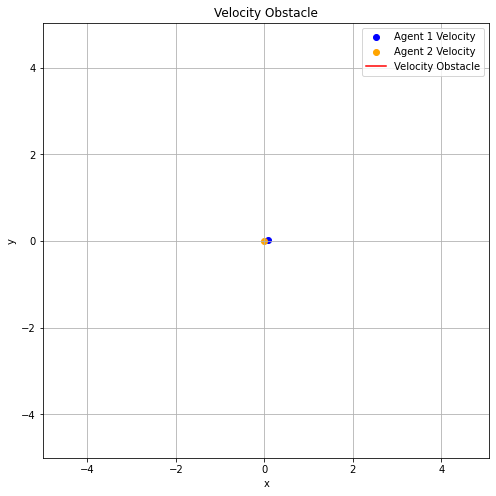

In [122]:
plot_velocity_obstacle(p1=x[:2], v1=[vel_x, vel_y], r1=ROBOT_RADIUS, p2=ob, v2=[0, 0], r2=OBS_RADIUS)